In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

TRAIN_IMG_DIR = './Data/images/train'
TEST_IMG_DIR = './Data/images/test'
TRAIN_CSV_PATH = './Data/CSV/train.csv'
TEST_CSV_PATH = './Data/CSV/test.csv'
IMAGE_SIZE = 224

In [2]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

print(f"Train CSV: {train_df.shape}")
print(f"Test CSV: {test_df.shape}")

Train CSV: (16209, 21)
Test CSV: (5404, 20)


In [3]:
def preprocess_tabular(df, is_train=True, scaler=None, encoder=None):
    df_proc = df.copy()

    df_proc = df_proc.drop(['id', 'date', 'lat', 'long'], axis=1, errors='ignore')

    df_proc['age'] = 2025 - df_proc['yr_built']

    df_proc['is_renovated'] = (df_proc['yr_renovated'] > 0).astype(int)
    df_proc['years_since_renovation'] = df_proc.apply(
        lambda x: 2025 - x['yr_renovated'] if x['yr_renovated'] > 0 else 0, axis=1
    )

    df_proc = df_proc.drop(['yr_built', 'yr_renovated'], axis=1)

    target = None
    if is_train and 'price' in df_proc.columns:
        target = df_proc['price'].copy()
        df_proc = df_proc.drop('price', axis=1)

    if 'zipcode' in df_proc.columns:
        if is_train:
            encoder = LabelEncoder()
            df_proc['zipcode'] = encoder.fit_transform(df_proc['zipcode'])
        else:
            df_proc['zipcode'] = encoder.transform(df_proc['zipcode'])

    numeric_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()

    if is_train or scaler is None:
        scaler = StandardScaler()
        df_proc[numeric_cols] = scaler.fit_transform(df_proc[numeric_cols])
    else:
        df_proc[numeric_cols] = scaler.transform(df_proc[numeric_cols])

    if target is not None:
        df_proc['price'] = target.values

    return df_proc, scaler, encoder

In [4]:
train_tabular, tab_scaler, zip_encoder = preprocess_tabular(train_df, is_train=True)
test_tabular, _, _ = preprocess_tabular(test_df, is_train=False, scaler=tab_scaler, encoder=zip_encoder)

print(f"Processed train tabular: {train_tabular.shape}")
print(f"Processed test tabular: {test_tabular.shape}")

Processed train tabular: (16209, 18)
Processed test tabular: (5404, 17)


In [5]:
def find_image_path(img_id, img_dir):
    img_id_str = str(img_id)
    possible_paths = [
        os.path.join(img_dir, img_id_str),
        os.path.join(img_dir, f"{img_id_str}.jpg"),
        os.path.join(img_dir, f"{img_id_str}.png"),
        os.path.join(img_dir, f"{img_id_str}.jpeg"),
        os.path.join(img_dir, f"{img_id_str}.JPG"),
        os.path.join(img_dir, f"{img_id_str}.PNG"),
        os.path.join(img_dir, f"{img_id_str}.JPEG"),
    ]
    for path in possible_paths:
        if os.path.exists(path):
            return path
    return None

In [6]:
image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
def load_all_images(img_dir):
    image_dict = {}
    missing_count = 0

    for filename in os.listdir(img_dir):
        file_path = os.path.join(img_dir, filename)

        if os.path.isfile(file_path):
            try:
                img_id = os.path.splitext(filename)[0]
                img = Image.open(file_path).convert('RGB')
                img_tensor = image_transform(img)
                image_dict[img_id] = img_tensor
            except:
                missing_count += 1

    print(f"Loaded {len(image_dict)} images, {missing_count} failed to load")
    return image_dict

In [8]:
train_images = load_all_images(TRAIN_IMG_DIR)


Loaded 16110 images, 0 failed to load


In [9]:
test_images = load_all_images(TEST_IMG_DIR)

Loaded 5396 images, 0 failed to load


In [10]:
train_tabular_features = train_tabular.drop('price', axis=1).values
train_prices = train_tabular['price'].values
test_tabular_features = test_tabular.values

train_tabular_tensor = torch.tensor(train_tabular_features, dtype=torch.float32)
train_price_tensor = torch.tensor(train_prices, dtype=torch.float32).view(-1, 1)
test_tabular_tensor = torch.tensor(test_tabular_features, dtype=torch.float32)

print(f"Train tabular tensor: {train_tabular_tensor.shape}")
print(f"Train prices tensor: {train_price_tensor.shape}")
print(f"Test tabular tensor: {test_tabular_tensor.shape}")

Train tabular tensor: torch.Size([16209, 17])
Train prices tensor: torch.Size([16209, 1])
Test tabular tensor: torch.Size([5404, 17])


In [11]:
train_image_list = list(train_images.values())
test_image_list = list(test_images.values())

train_image_tensor = torch.stack(train_image_list) if train_image_list else None
test_image_tensor = torch.stack(test_image_list) if test_image_list else None

print(f"Train images tensor: {train_image_tensor.shape}")
print(f"Test images tensor: {test_image_tensor.shape}")

Train images tensor: torch.Size([16110, 3, 224, 224])
Test images tensor: torch.Size([5396, 3, 224, 224])


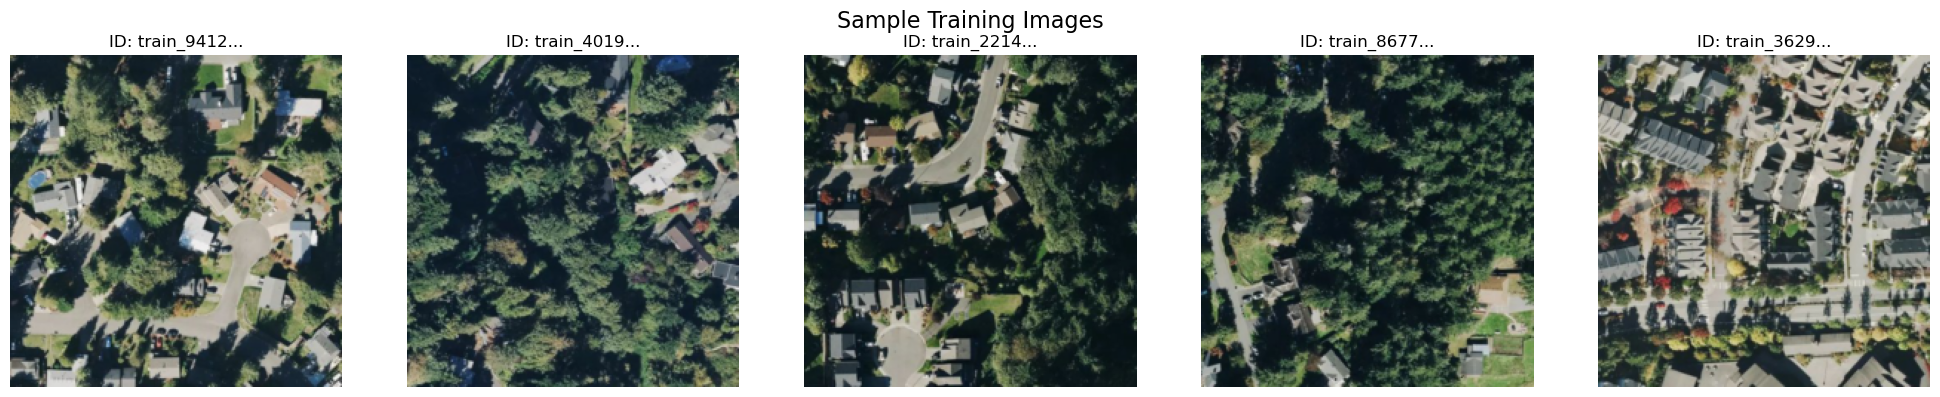

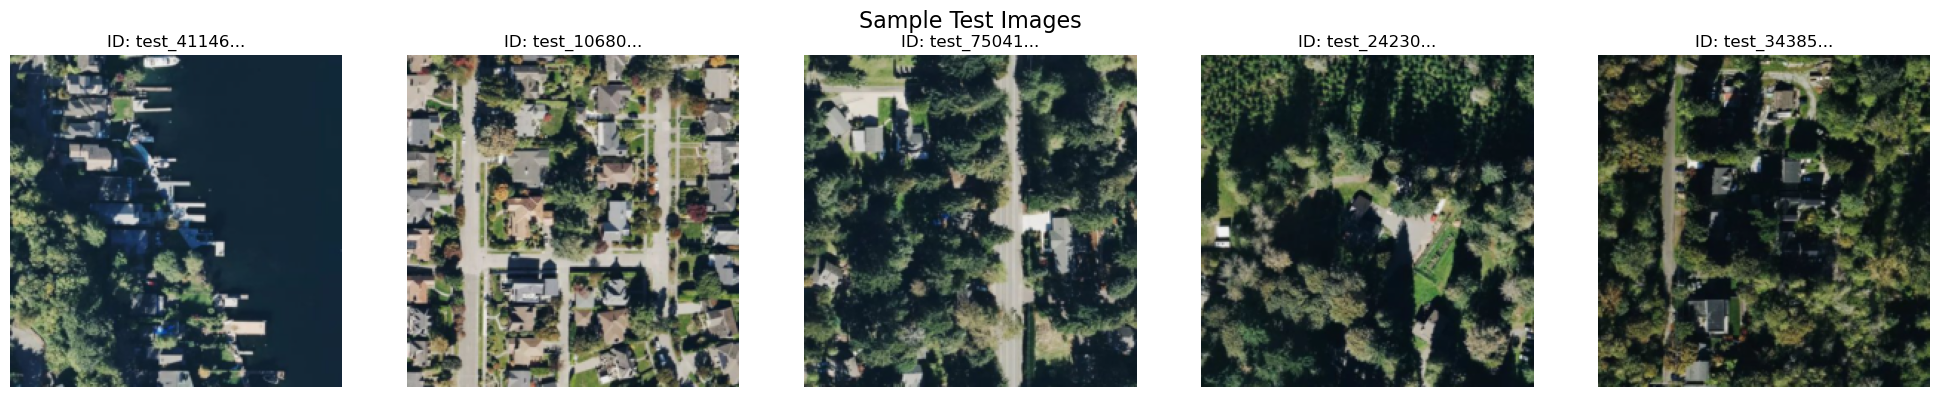

In [12]:
def visualize_sample_images(image_dict, title="Sample Images"):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    sample_ids = list(image_dict.keys())[:5]

    for idx, (ax, img_id) in enumerate(zip(axes, sample_ids)):
        img_tensor = image_dict[img_id]
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img_np = np.clip(img_np, 0, 1)

        ax.imshow(img_np)
        ax.set_title(f"ID: {img_id[:10]}...")
        ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_sample_images(train_images, "Sample Training Images")
visualize_sample_images(test_images, "Sample Test Images")

In [13]:
torch.save({
    'train_tabular': train_tabular_tensor,
    'train_prices': train_price_tensor,
    'train_images': train_image_tensor,
    'test_tabular': test_tabular_tensor,
    'test_images': test_image_tensor,
    'scaler': tab_scaler,
    'encoder': zip_encoder,
    'train_tabular_cols': train_tabular.drop('price', axis=1).columns.tolist()
}, 'processed_data.pt')

print("Preprocessing complete! Data saved to processed_data.pt")

Preprocessing complete! Data saved to processed_data.pt


In [ ]:
train_tabular.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,age,is_renovated,years_since_renovation,price
0,0.677402,0.178963,-0.290276,-0.144952,0.922943,-0.083788,-0.306964,-0.626000,-0.557611,0.030720,-0.657843,-0.269415,-0.473911,-0.129791,0.345663,-0.20797,-0.183085,268643
1,-0.394132,0.505667,-0.521813,-0.311135,0.922943,-0.083788,-0.306964,0.908842,-0.557611,-0.224818,-0.657843,-0.842519,-0.385919,-0.339019,-0.709771,-0.20797,-0.183085,245000
2,0.677402,0.505667,-0.389506,-0.160457,0.922943,-0.083788,-0.306964,-0.626000,0.296350,-0.078796,-0.657843,-1.728225,-0.165941,-0.196068,-0.777864,-0.20797,-0.183085,200000
3,-1.465666,0.178963,-0.918734,-0.364787,0.922943,-0.083788,-0.306964,-0.626000,-0.557611,-0.772399,-0.452638,-1.050920,-1.089851,-0.445025,-1.288558,-0.20797,-0.183085,352499
4,-0.394132,-0.147741,-0.874632,-0.038936,-0.918626,-0.083788,-0.306964,-0.626000,-0.557611,-0.614209,-0.657843,-0.477816,-0.576568,-0.173196,-0.777864,-0.20797,-0.183085,232000


: 